### Agentic RAG

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


In [ ]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [ ]:
urls=[
    "https://langchain-ai.github.io/langgraph/tutorials/introduction/",
    "https://langchain-ai.github.io/langgraph/tutorials/workflows/",
    "https://langchain-ai.github.io/langgraph/how-tos/map-reduce/"
]

docs=[WebBaseLoader(url).load() for url in urls]
docs


In [12]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100
)

doc_splits = text_splitter.split_documents(docs_list)

## Add alll these text to vectordb

vectorstore=FAISS.from_documents(
    documents=doc_splits,
    embedding=HuggingFaceEmbeddings()
)


retriever=vectorstore.as_retriever()

In [ ]:
retriever.invoke("what is langgraph")

In [14]:
### Retriever To Retriever Tools
from langchain_core.tools import create_retriever_tool



retriever_tool=create_retriever_tool(
    retriever,
    "retriever_vector_db_blog",
    "Search and run information about Langgraph"
)

In [ ]:
retriever_tool

### Langchain Blogs- Seperate Vector Store


In [ ]:
langchain_urls=[
    "https://python.langchain.com/docs/tutorials/",
    "https://python.langchain.com/docs/tutorials/chatbot/",
    "https://python.langchain.com/docs/tutorials/qa_chat_history/"
]

docs=[WebBaseLoader(url).load() for url in langchain_urls]
docs

In [17]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100
)

doc_splits = text_splitter.split_documents(docs_list)

## Add alll these text to vectordb

vectorstorelangchain=FAISS.from_documents(
    documents=doc_splits,
    embedding=HuggingFaceEmbeddings()
)


retrieverlangchain=vectorstorelangchain.as_retriever()

In [18]:
from langchain_core.tools import create_retriever_tool

retriever_tool_langchain=create_retriever_tool(
    retrieverlangchain,
    "retriever_vector_langchain_blog",
    "Search and run information about Langchain"
)

In [19]:
import os
import requests
from langchain.tools import tool

@tool
def get_weather(city: str) -> str:
    """Get current weather for a given city."""
    
    api_key = os.getenv("WEATHER_API_KEY")
    if not api_key:
        return "Weather API key not set"

    url = f"https://api.weatherapi.com/v1/current.json?key={api_key}&q={city}"
    resp = requests.get(url)
    data = resp.json()

    if "error" in data:
        return f"Weather API error: {data['error']['message']}"

    return f"{data['location']['name']} is {data['current']['temp_c']}°C"

get_weather.invoke({"city": "bengaluru"})


'Bengaluru is 19.3°C'

In [53]:
tools=[retriever_tool,retriever_tool_langchain,get_weather]

In [ ]:
tools

### LangGraph Workflow

In [55]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],add_messages]

In [ ]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")
llm.invoke("hi")

In [ ]:
def agent(state):
    """
    Invokes the agent model to generate a response based on current state. Given the question, it will decide to retrieve using 
    the retriever tools, for weather related questions use get_weather tool.
    
    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the response added to the messages
    
    
    """
    
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    return {
        "messages": messages + [response]
        }


In [60]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain_classic import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from pydantic import BaseModel, Field

In [ ]:
### Edges
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

In [ ]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [ ]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")
    response = model.invoke(msg)
    return {"messages": [response]}

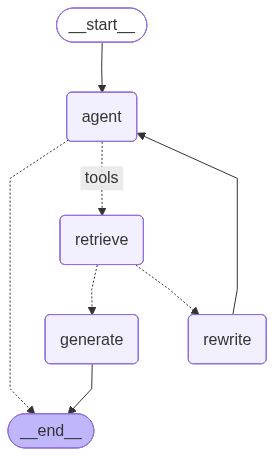

In [64]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool,retriever_tool_langchain,get_weather])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [ ]:
#EVAL

EVAL_SET = [
    {
        "question": "what is langchain?",
        "expected_keywords": ["langchain"]
    },
    {
        "question": "what is langgraph?",
        "expected_keywords": ["langgraph"]
    },
    {
        "question": "What is the weather in Delhi?",
        "expected_keywords": ["Delhi", "°C"]
    }
]


In [79]:
from langchain_core.messages import HumanMessage

def call_agent(question: str):
    # initial state for your agent
    state = {
        "messages": [HumanMessage(content=question)]
    }

    final_state = graph.invoke(state)

    # last message is model output
    last_message = final_state["messages"][-1]

    return last_message.content

In [ ]:
def run_eval(eval_set):
    passed = 0
    results = []

    for item in eval_set:
        q = item["question"]
        expected = item["expected_keywords"]

        print(f"\nQ: {q}")
        answer = call_agent(q)
        print(f"A: {answer}")

        score = all(word.lower() in answer.lower() for word in expected)

        if score:
            print("✅ PASS")
            passed += 1
        else:
            print("❌ FAIL")

        results.append({
            "question": q,
            "answer": answer,
            "passed": score
        })

    accuracy = passed / len(eval_set)
    print(f"\nFinal accuracy: {accuracy * 100:.2f}%")

    return results, accuracy



In [ ]:
# ===== CI ENTRYPOINT =====

results, accuracy = run_eval(EVAL_SET)

# Fail CI if accuracy is too low
if accuracy < 0.6:
    raise Exception("Evaluation accuracy below threshold")
